In [1]:
import cv2
import numpy as np


In [2]:
# Edge detection using Sobel operator
def extract_edge(image_array):
  edgesX = cv2.Sobel(image_array, cv2.CV_64F, 1, 0, ksize=3)
  edgesY = cv2.Sobel(image_array, cv2.CV_64F, 0, 1, ksize=3)
  absEdgesX = cv2.convertScaleAbs(edgesX)
  absEdgesY = cv2.convertScaleAbs(edgesY)
  edges = cv2.addWeighted(absEdgesX, 0.5, absEdgesY, 0.5, 0)
  return edges

In [ ]:
def extract_corner(image_array):
  # Apply cornerHarris
  score = cv2.cornerHarris(image_array, 2, 3, 0.04)
  # 0.05 is a threshold to determine if a corner is valid
  corners = score > 0.05 * score.max()

  # Could consider returning original score without thresholding
  return corners


In [4]:
def extract_blob(image_array):
  # Use DoG (Difference of Gaussian) to detect blobs
  # First, apply GaussianBlur to the image
  blurred1 = cv2.GaussianBlur(image_array, (5, 5), 0)
  blurred2 = cv2.GaussianBlur(image_array, (11, 11), 0)

  # Then, compute the difference between the blurred image and the original image
  dog = cv2.subtract(blurred1, blurred2)

  # minmax normalize the result to enhance contrast
  dog = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX)

  return dog

In [ ]:
def extract_local_binary_pattern(image_array):
  # Get image dimensions
  height, width = image_array.shape

  # Initialize LBP image
  lbp_image = np.zeros_like(image_array)

  # Define 8-neighborhood offsets (8-connected)
  offsets = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]

  # Apply LBP to each pixel (excluding border pixels)
  for i in range(1, height - 1):
    for j in range(1, width - 1):
      center_pixel = image_array[i, j]
      binary_pattern = 0

      # Compare center pixel with 8 neighbors
      for k, (di, dj) in enumerate(offsets):
        neighbor_pixel = image_array[i + di, j + dj]
        if neighbor_pixel >= center_pixel:
          binary_pattern |= (1 << k)

      lbp_image[i, j] = binary_pattern

  return lbp_image


In [6]:
def extract_gabor_feature(image_array):
  # Define Gabor filter parameters
  orientations = [0, 45, 90, 135]  # 4 orientations in degrees
  frequencies = [0.1, 0.2, 0.3]   # 3 different frequencies
  sigma = 2.0  # Standard deviation of Gaussian envelope
  gamma = 0.5  # Spatial aspect ratio

  # Initialize feature maps
  gabor_features = []

  # Apply Gabor filters with different orientations and frequencies
  for orientation in orientations:
    for frequency in frequencies:
      # Convert orientation to radians
      theta = np.radians(orientation)

      # Create Gabor kernel
      kernel = cv2.getGaborKernel(
        ksize=(15, 15),  # Kernel size
        sigma=sigma,
        theta=theta,
        lambd=1.0/frequency,  # Wavelength
        gamma=gamma,
        psi=0,  # Phase offset
        ktype=cv2.CV_32F
      )

      # Apply filter
      filtered = cv2.filter2D(image_array, cv2.CV_32F, kernel)

      # Take magnitude of response
      magnitude = np.abs(filtered)

      # Normalize to 0-255 range
      magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

      gabor_features.append(magnitude)

  # Combine all Gabor responses (mean of all filter responses)
  combined_gabor = np.mean(gabor_features, axis=0)

  return combined_gabor


In [14]:
import pydicom

# Read indivudal scans from DICOM files
def read_dicom(path):
  dicom = pydicom.dcmread(path)
  # Convert image to float32
  image_array = np.float32(dicom.pixel_array)
  return image_array

In [ ]:
import os
import pandas as pd

from preprocess import preprocess_dicom

tabular = pd.read_csv('../data/train.csv')
patient_ids = tabular['Patient'].unique()

scan = dict()
for patient_id in patient_ids[:10]:
  # Read and concatenate all scans for a given patient
  patient_scans = []
  for i in range(1, len(os.listdir(f'../data/train/{patient_id}/')) + 1):
    try:
      dcm = pydicom.dcmread(f'../data/train/{patient_id}/{i}.dcm')
      preprocessed_scan = preprocess_dicom(dcm)
      patient_scans.append(preprocess_dicom(dcm))
    except:
      print(f'Error reading {patient_id}')
      break
  patient_scans = np.array(patient_scans, dtype=np.float32)
  scan[patient_id] = patient_scans



Error reading ID00011637202177653955184
Error reading ID00015637202177877247924


In [16]:
def extract_features(scan):
  features = []
  features.append(extract_edge(scan))
  features.append(extract_corner(scan))
  features.append(extract_blob(scan))
  features.append(extract_local_binary_pattern(scan))
  features.append(extract_gabor_feature(scan))
  return features

In [26]:
for key, value in scan.items():
  for scanSlice in value:
    features = extract_features(scanSlice)
    break
  break


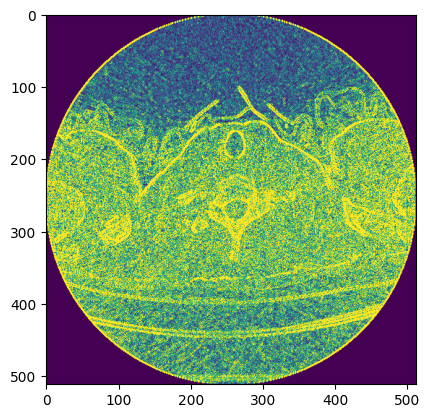

In [29]:
import matplotlib.pyplot as plt

plt.imshow(features[0])